# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Do a principal components analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].  Also show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.

Notes:
* You can use `PCA` to produce a PCA analysis.

In [98]:
def P1(components, dataset):
    # Conduct principal component analysis
    for k in components:
        pca = PCA(n_components=k)
        pca.fit_transform(dataset)
    print("Percentage of Variance Explained by Principal Components")
    print("-"*60)
    for value, ratio in zip(components, pca.explained_variance_ratio_):
        print("Percentage of variance explained by first {} principal components: {}%"
              .format(value, round(ratio*100, 2)))
    print("-"*60)
    # Plot graph
    plt.figure(figsize=(7,4))
    plt.plot([index for index,values in enumerate(pca.explained_variance_ratio_)], 
             [sum(pca.explained_variance_ratio_[:i])*100 for i in range(len(pca.explained_variance_ratio_))],
            color='green')
    plt.xlabel("Number of Components") 
    plt.ylabel("% of Explained Variance")
    plt.title("Percentage of Explained Variance vs. Number of Components")
    
    return

Percentage of Variance Explained by Principal Components
------------------------------------------------------------
Percentage of variance explained by first 1 principal components: 16.4%
Percentage of variance explained by first 2 principal components: 13.32%
Percentage of variance explained by first 3 principal components: 10.17%
Percentage of variance explained by first 4 principal components: 7.06%
Percentage of variance explained by first 5 principal components: 3.87%
Percentage of variance explained by first 10 principal components: 3.68%
Percentage of variance explained by first 20 principal components: 3.13%
Percentage of variance explained by first 30 principal components: 2.73%
Percentage of variance explained by first 40 principal components: 2.62%
Percentage of variance explained by first 50 principal components: 2.23%
------------------------------------------------------------


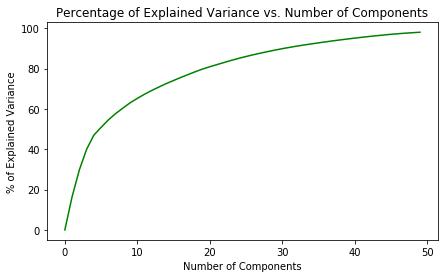

In [99]:
components = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
P1(components, train_data)

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and show as a square scatterplot. Show the positive (poisonous) examples in red and the negative (non-poisonous) examples in green. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.

In [84]:
def P2(dataset):
    # Fit model
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(dataset)
    
    # Determine label colors
    labels = {0:'green', 1:'red'}
    label_color = [labels[l] for l in train_labels]
    
    # Plot
    plt.figure(figsize=(10,10))
    plt.scatter(pca_fit[:, 0], pca_fit[:, 1], s=50, alpha=0.1, c=label_color)
    plt.scatter([], [], s=50, c='red', alpha=1,label="Poisonous")
    plt.scatter([], [], s=50, c='green', alpha=1,label="Non-Poisonous")
    plt.xlabel("Principal Component 1", fontsize=15)
    plt.ylabel("Principal Component 2", fontsize=15)
    plt.title("Scatter Plot of Training Data Projected Onto 2-Dimensions Using PCA", fontsize=15)
    plt.legend()
    
    return 


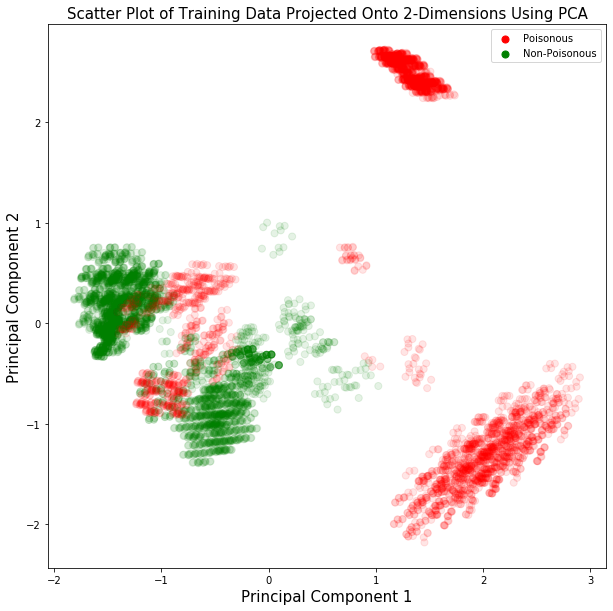

In [85]:
P2(train_data)

### Part 3:

Fit a k-means cluster model with 6 clusters over the 2d projected data. As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

In [88]:
def P3(dataset, n_clusters):
    # Fit model to 2d data
    pca = PCA(n_components=2)
    pca_fit_2 = pca.fit_transform(dataset)
    
    # Fit a K-means model to the pre-processed data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_fit = kmeans.fit(pca_fit_2)
    kmeans_predict = kmeans.predict(pca_fit_2)
    centers = kmeans.cluster_centers_

    # Plot baseline scatterplot
    labels = {0:'green', 1:'red'}
    label_color = [labels[l] for l in train_labels]
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.axis('equal')
    ax.scatter(pca_fit_2[:, 0], pca_fit_2[:, 1], s=50, alpha=0.3, c=label_color)
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
    ax.scatter([], [], s=50, c='red',alpha=1,label="Poisonous")
    ax.scatter([], [], s=50, c='green',alpha=1,label="Non-Poisonous")
    ax.set_xlabel("Principal Component 1", fontsize=15)
    ax.set_ylabel("Principal Component 2", fontsize=15)
    ax.set_title("Scatter Plot Showing {} Clusters for 2-D PCA Data".format(n_clusters), fontsize=15)
    ax.legend()
    
    # Plot circles
    for i in range(n_clusters):
        inds = np.where(kmeans.labels_ == i)[0]
        radius = np.max(np.linalg.norm(pca_fit_2[inds] - kmeans.cluster_centers_[i], axis = 1))
        circle = plt.Circle(centers[i], radius, alpha=0.1, color="blue")
        ax.add_patch(circle)
        
    return 

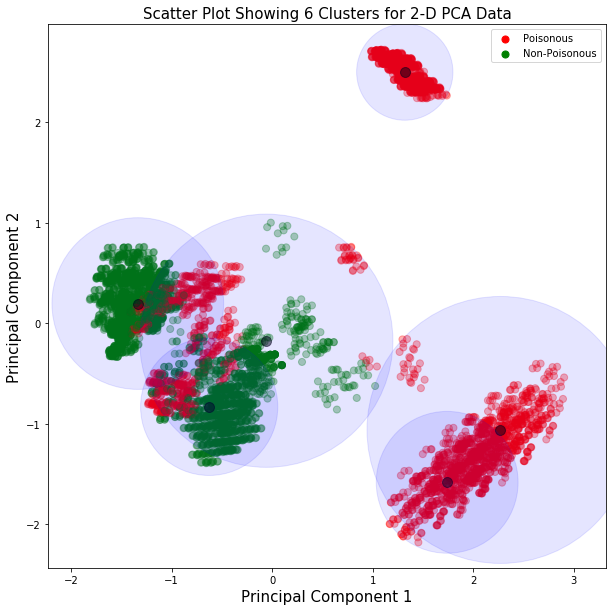

In [89]:
P3(train_data, 6)

### Part 4:

Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  Show square plots of the estimated density contours presented in a 4x4 grid - one row each for a number of mixture components and one column each for a convariance matrix type.  

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

In [24]:
def P4(dataset, labels):
    # Fit PCA model
    pca = PCA(n_components=2)
    pca_fit_3 = pca.fit_transform(dataset)
    
    # Create list of poisonous examples only
    positive_list = []
    for index, value in enumerate(labels):
        if value == 1:
            positive_list.append(pca_fit_3[index])
        else:
            pass
    
    positive_list = np.array(positive_list)
    
    x = list(positive_list[:, 0].astype(float))
    y = list(positive_list[:, 1].astype(float))

    # Fit Gaussian mixture model 
    fig, ax = plt.subplots(4,4, figsize=(15,15), squeeze=False)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for component in range(1,5):
        for cv_type, indexer in zip(['spherical', 'diag', 'tied', 'full'], range(1,5)):
            
            # Specify and train Gaussian mixture model
            GM = GaussianMixture(n_components=component, covariance_type=cv_type, random_state=12345)
            GM.fit(positive_list)
            
            # Specify parameters for contour plots
            a = np.linspace(-3.0, 4.0)
            b = np.linspace(-2.5, 3.0)
            A,B = np.meshgrid(a,b)
            AA = np.array([A.ravel(), B.ravel()]).T
            C = -(GM.score_samples(AA))
            C = C.reshape(A.shape)
            
            # Plot scatterplots of only poisonous mushrooms for all subplots
            ax[component-1, indexer-1].scatter(x, y, s=50, alpha=0.1, c='r')
            ax[component-1, indexer-1].set_xlabel("Component 1")
            ax[component-1, indexer-1].set_ylabel("Component 2", labelpad=0.01)
            
            # Plot contours
            CS = ax[component-1, indexer-1].contour(A, B, C, 
                                               norm=LogNorm(vmin=1.0, vmax=1000.0),
                                               levels=np.logspace(0, 3, 10))
    
    # Add labels to top of axes   
    for ax, ax2, col, row in zip(ax[0], ax[:,0], ['Spherical', 'Diag', 'Tied', 'Full'], range(1,5)):
        ax.set_title("Matrix: {}".format(col), fontsize=15)
        ax2.set_ylabel("Mixture Components: {}".format(str(row)), fontsize=15, labelpad=0.5)
        
    return 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Log scale: values of z <= 0 have been masked
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Log scale: values of z <= 0 have been masked
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Log scale: values of z <= 0 have been masked
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Log scale: values of z <= 0 have been masked
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Log scale: values of z <= 0 have been masked
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Log scale: values of z <= 0 have been masked


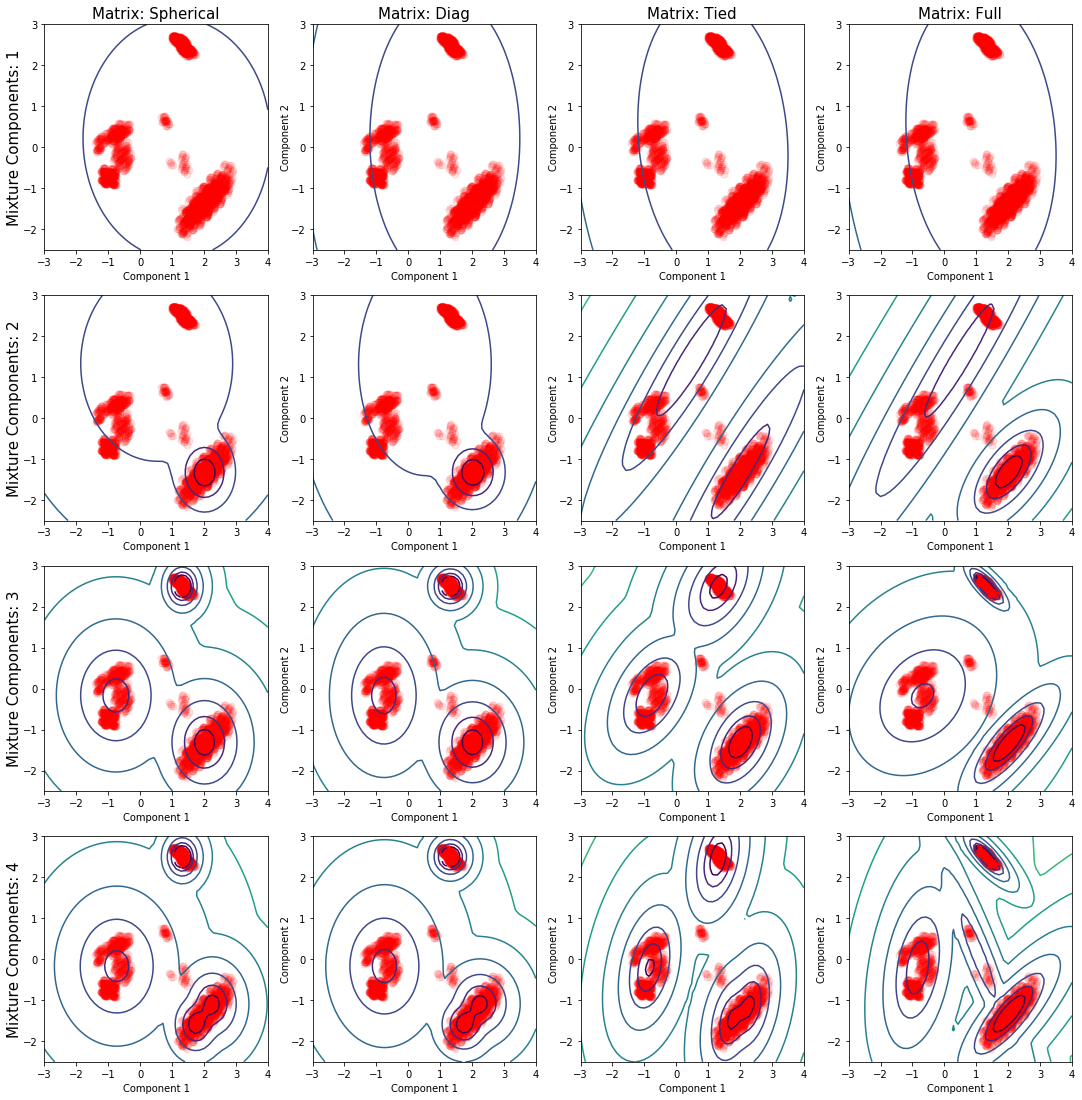

In [25]:
P4(train_data, train_labels)

### Part 5:

Fit two Gaussian mixture models, one for the positive examples and one for the negative examples in your 2d projected data. Use 4 mixture components and full convariance for each model.  Predict the test example labels by picking the labels corresponding to the larger of the two models' probabilities.  What is the accuracy of you predictions on the test data?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [26]:
def P5(train_data, train_labels, test_data, test_labels):

    # Fit PCA model, get positive and negative datasets
    pca = PCA(n_components=2)
    pca_fit_4 = pca.fit_transform(train_data)
    pca_fit_5 = pca.transform(test_data)
    
    # Create 2 Gaussian models for each dataset and use to predict on test dataset
    GM1 = GaussianMixture(n_components=4, covariance_type='full', random_state=12345)
    pos = GM1.fit(pca_fit_4[train_labels==1])
    GM2 = GaussianMixture(n_components=4, covariance_type='full', random_state=12345)
    neg = GM2.fit(pca_fit_4[train_labels==0])
    pos_score = np.exp(pos.score_samples(pca_fit_5))
    neg_score = np.exp(neg.score_samples(pca_fit_5))
    
    # Score both samples
    pred_labels = pos_score > neg_score

    # Calculate accuracy
    accuracy = np.sum(pred_labels==test_labels)/len(pred_labels)
    
    # Print Statement
    print("The accuracy is: {}".format(round(accuracy, 3)))
    
    return 

In [27]:
P5(train_data, train_labels, test_data, test_labels)

The accuracy is: 0.95


### Part 6:

Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.


* For spherical, diag, and full covariance types:
  * number of parameters = (number of parameters per gmm component * number of gmm components - 1) * number of classes
  * number of parameters per gmm component includes all the means plus all the non-zero, non-duplicated values in the covariance matrix plus the mixing weight
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter


* To calculate the number of parameters for tied covariance type:
  * number of parameters = (number of parameters per class - 1) * number of classes
  * number of parameters per class includes all the means and mixing weights for all the gmm components plus all the non-zero, non-duplicated values in the one shared covariance matrix
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter

In [90]:
def P6(train_dataset, train_labels, test_dataset, test_labels):
    
    # Define a sub-function that can be called multiple times (based on function from P5). 
    def model(pca_comp, gmm_comp, covariance_type):
        
        # Define/fit PCA models
        pca = PCA(n_components=pca_comp)
        pca_train = pca.fit_transform(train_dataset)
        pca_test = pca.transform(test_dataset)
        
        # Define/fit GMM models
        gmm1 = GaussianMixture(n_components=gmm_comp, covariance_type=covariance_type)
        gmm2 = GaussianMixture(n_components=gmm_comp, covariance_type=covariance_type)
        
        # Create positive and negative GMM fits
        pos = gmm1.fit(pca_train[train_labels==1])
        neg = gmm2.fit(pca_train[train_labels==0])
        
        # Score models
        pos_score = np.exp(pos.score_samples(pca_test))
        neg_score = np.exp(neg.score_samples(pca_test))
        
        # Calculate higher probs + accuracy
        pred_labels = pos_score > neg_score
        accuracy = np.sum(pred_labels==test_labels)/len(pred_labels)
        
        return accuracy
    
    # Initialize covariance matrix types
    cov = ['spherical', 'diag', 'tied', 'full']
    
    # Initialize empty lists to create table
    total_components = []
    pca_components = []
    gmm_components = []
    cov_type = []
    accuracy = []
    
    # Get optimum scores
    opt_pca_comps = 0
    opt_gmm_comps = 0
    opt_cov_type = 0
    opt_accuracy = 0
    
    # Loop to calculate
    for i in range(1,16):
        for j in range(1,16):
            for k in cov:
                if k == 'full' and ((i*j + i*(i+1))/2*j)*2 < 50:
                    acc = model(i, j, k) # Calculate accuracy
                    total_components.append((i*j + i*(i+1)/ 2*j)*2)
                    pca_components.append(i)
                    gmm_components.append(j)
                    cov_type.append(k)
                    accuracy.append(round(acc, 2))
                    if acc > opt_accuracy:
                        opt_pca_comps = i
                        opt_gmm_comps = j
                        opt_cov_type = k
                        opt_accuracy = acc
                    else:
                        pass

                    
                elif k == 'diag' and (i*j + i*j)*2 < 50:
                    acc = model(i, j, k) # Calculate accuracy
                    total_components.append((i*j + i*j)*2)
                    pca_components.append(i)
                    gmm_components.append(j)
                    cov_type.append(k)
                    accuracy.append(round(acc, 2))
                    if acc > opt_accuracy:
                        opt_pca_comps = i
                        opt_gmm_comps = j
                        opt_cov_type = k
                        opt_accuracy = acc
                    else:
                        pass

                    
                elif k == 'spherical' and ((i*j) + j)*2 < 50: 
                    acc = model(i, j, k) # Calculate accuracy
                    total_components.append((i*j + j)*2)
                    pca_components.append(i)
                    gmm_components.append(j)
                    cov_type.append(k)
                    accuracy.append(round(acc, 2))
                    if acc > opt_accuracy:
                        opt_pca_comps = i
                        opt_gmm_comps = j
                        opt_cov_type = k
                        opt_accuracy = acc
                    else:
                        pass

                    
                elif k == 'tied' and (i*j + i*(i+1)/ 2)*2 < 50:
                    acc = model(i, j, k) # Calculate accuracy
                    total_components.append((i*j + i*(i+1)/ 2)*2)
                    pca_components.append(i)
                    gmm_components.append(j)
                    cov_type.append(k)
                    accuracy.append(round(acc, 2))
                    if acc > opt_accuracy:
                        opt_pca_comps = i
                        opt_gmm_comps = j
                        opt_cov_type = k
                        opt_accuracy = acc
                    else:
                        pass

                    
    # Plot a table using matplotlib table function
    master_array = np.column_stack((total_components, pca_components, 
                                    gmm_components, cov_type, accuracy))
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()
    ax.table(cellText=master_array,
                      colLabels=['Total Components', 'PCA Components', 
                                 'GMM Components', 'Cov-Type', 'Accuracy'],
                      loc='top')
    plt.axis('off')
    
    # Print some statements regarding optimal performance:
    print("The highest performing model achieved an accuracy of {}, with {} PCA components, {} GMM components and a {} type covariance matrix"
          .format(round(opt_accuracy, 2), opt_pca_comps, opt_gmm_comps, opt_cov_type))
    
    return 
                        

The highest performing model achieved an accuracy of 0.97, with 5 PCA components, 4 GMM components and a spherical type covariance matrix


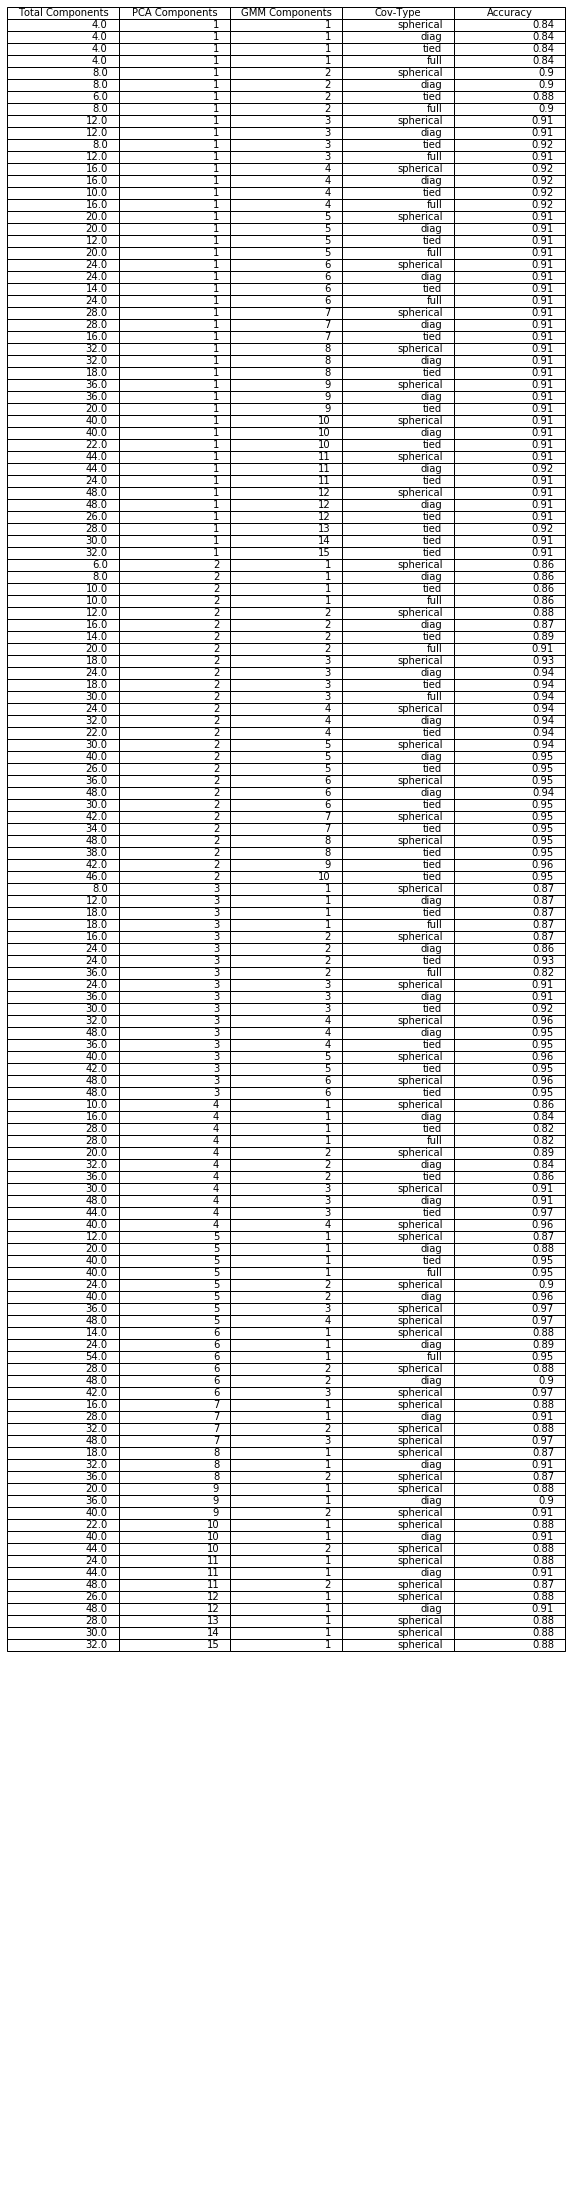

In [91]:
P6(train_data, train_labels, test_data, test_labels)